In [27]:
#librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold

**1. Exploración Inicial y Análisis Descriptivo (EDA)**

In [28]:

# Cargamos el archivo CSV sin cabecera
df = pd.read_csv("mitbih_train.csv", header=None)

# dimensiones del conjunto de datos
print("Dimensiones del dataset (filas, columnas):", df.shape)

# para confirmar estructura
print("\nPrimeras 5 filas del dataset:")
print(df.head())

print("\n¿Existen valores nulos en el dataset?", df.isnull().values.any())

# (debería ser numérico)
print("\nTipos de datos por columna:")
print(df.dtypes.value_counts())

# Separamos señales (X) y etiquetas (y)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Verificamos las clases únicas de la etiqueta
print("\nEtiquetas originales:")
print(y.value_counts().sort_index())

# Creamos una columna de etiquetas binarias: 0 = normal, 1 = anómalo
y_binaria = y.apply(lambda x: 0 if x == 0 else 1)
print(y_binaria.value_counts())

#  valores extremos en las señales
print("\nValor mínimo y máximo en las señales:")
print("Mínimo:", X.min().min())
print("Máximo:", X.max().max())



Dimensiones del dataset (filas, columnas): (87554, 188)

Primeras 5 filas del dataset:
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0 

Tamaño del conjunto de datos:
El dataset contiene 87.554 registros (latidos) y 188 columnas. De ellas, 187 son valores de la señal ECG y 1 es la etiqueta de clase.

Primer vistazo a los datos:
Todas las señales están en un rango de 0 a 1, lo que indica que ya vienen normalizadas. Las últimas columnas tienen muchos ceros, lo que puede indicar que son partes del latido sin actividad o añadidas como relleno.

Datos completos:
No hay valores nulos ni errores visibles. Todos los datos están en formato numérico (float64), por lo que se pueden analizar directamente sin limpieza.
Clases originales (5 tipos de latidos):

Clase 0 (normal): 72.471 registros

Clase 1: 2.223

Clase 2: 5.788

Clase 3: 641

Clase 4: 6.431

Hay un gran desbalance: casi todo el dataset pertenece a la clase 0 (normal).

Clases binarias (normal vs. anómalo):

Normal (0): 72.471

Anómalo (1): 15.083

Aunque sigue habiendo más normales, este enfoque binario es más equilibrado y manejable para entrenar un modelo.

Valores en la señal:
Todos los valores están entre 0 y 1, así que no es necesario escalar ni transformar las señales.

In [29]:
# Calculamos estadísticas básicas para todas las columnas de señal
descripcion_general = X.describe().T  # Transponemos para visualizar mejor

#: rango, varianza, simetría...
descripcion_general["rango"] = X.max() - X.min()
descripcion_general["varianza"] = X.var()
descripcion_general["simetria"] = X.skew()

# Mostramos los primeros resultados para revisar
descripcion_general.head(10)


,count,mean,std,min,25%,50%,75%,max,rango,varianza,simetria
0,87554.0,0.890360,0.240909,0.0,0.921922,0.991342,1.000000,1.0,1.0,0.058037,-2.843366
1,87554.0,0.758160,0.221813,0.0,0.682486,0.826013,0.910506,1.0,1.0,0.049201,-1.662416
2,87554.0,0.423972,0.227305,0.0,0.250969,0.429472,0.578767,1.0,1.0,0.051668,0.114203
3,87554.0,0.219104,0.206878,0.0,0.048458,0.166000,0.341727,1.0,1.0,0.042799,1.082360
4,87554.0,0.201127,0.177058,0.0,0.082329,0.147878,0.258993,1.0,1.0,0.031349,1.577160
5,87554.0,0.210399,0.171909,0.0,0.088416,0.158798,0.287628,1.0,1.0,0.029553,1.386956
6,87554.0,0.205808,0.178481,0.0,0.073333,0.145324,0.298237,1.0,1.0,0.031856,1.278160
7,87554.0,0.201773,0.177240,0.0,0.066116,0.144424,0.295391,1.0,1.0,0.031414,1.250986
8,87554.0,0.198691,0.171778,0.0,0.065000,0.150000,0.290832,1.0,1.0,0.029508,1.237625
9,87554.0,0.196757,0.168357,0.0,0.068639,0.148734,0.283636,1.0,1.0,0.028344,1.349126


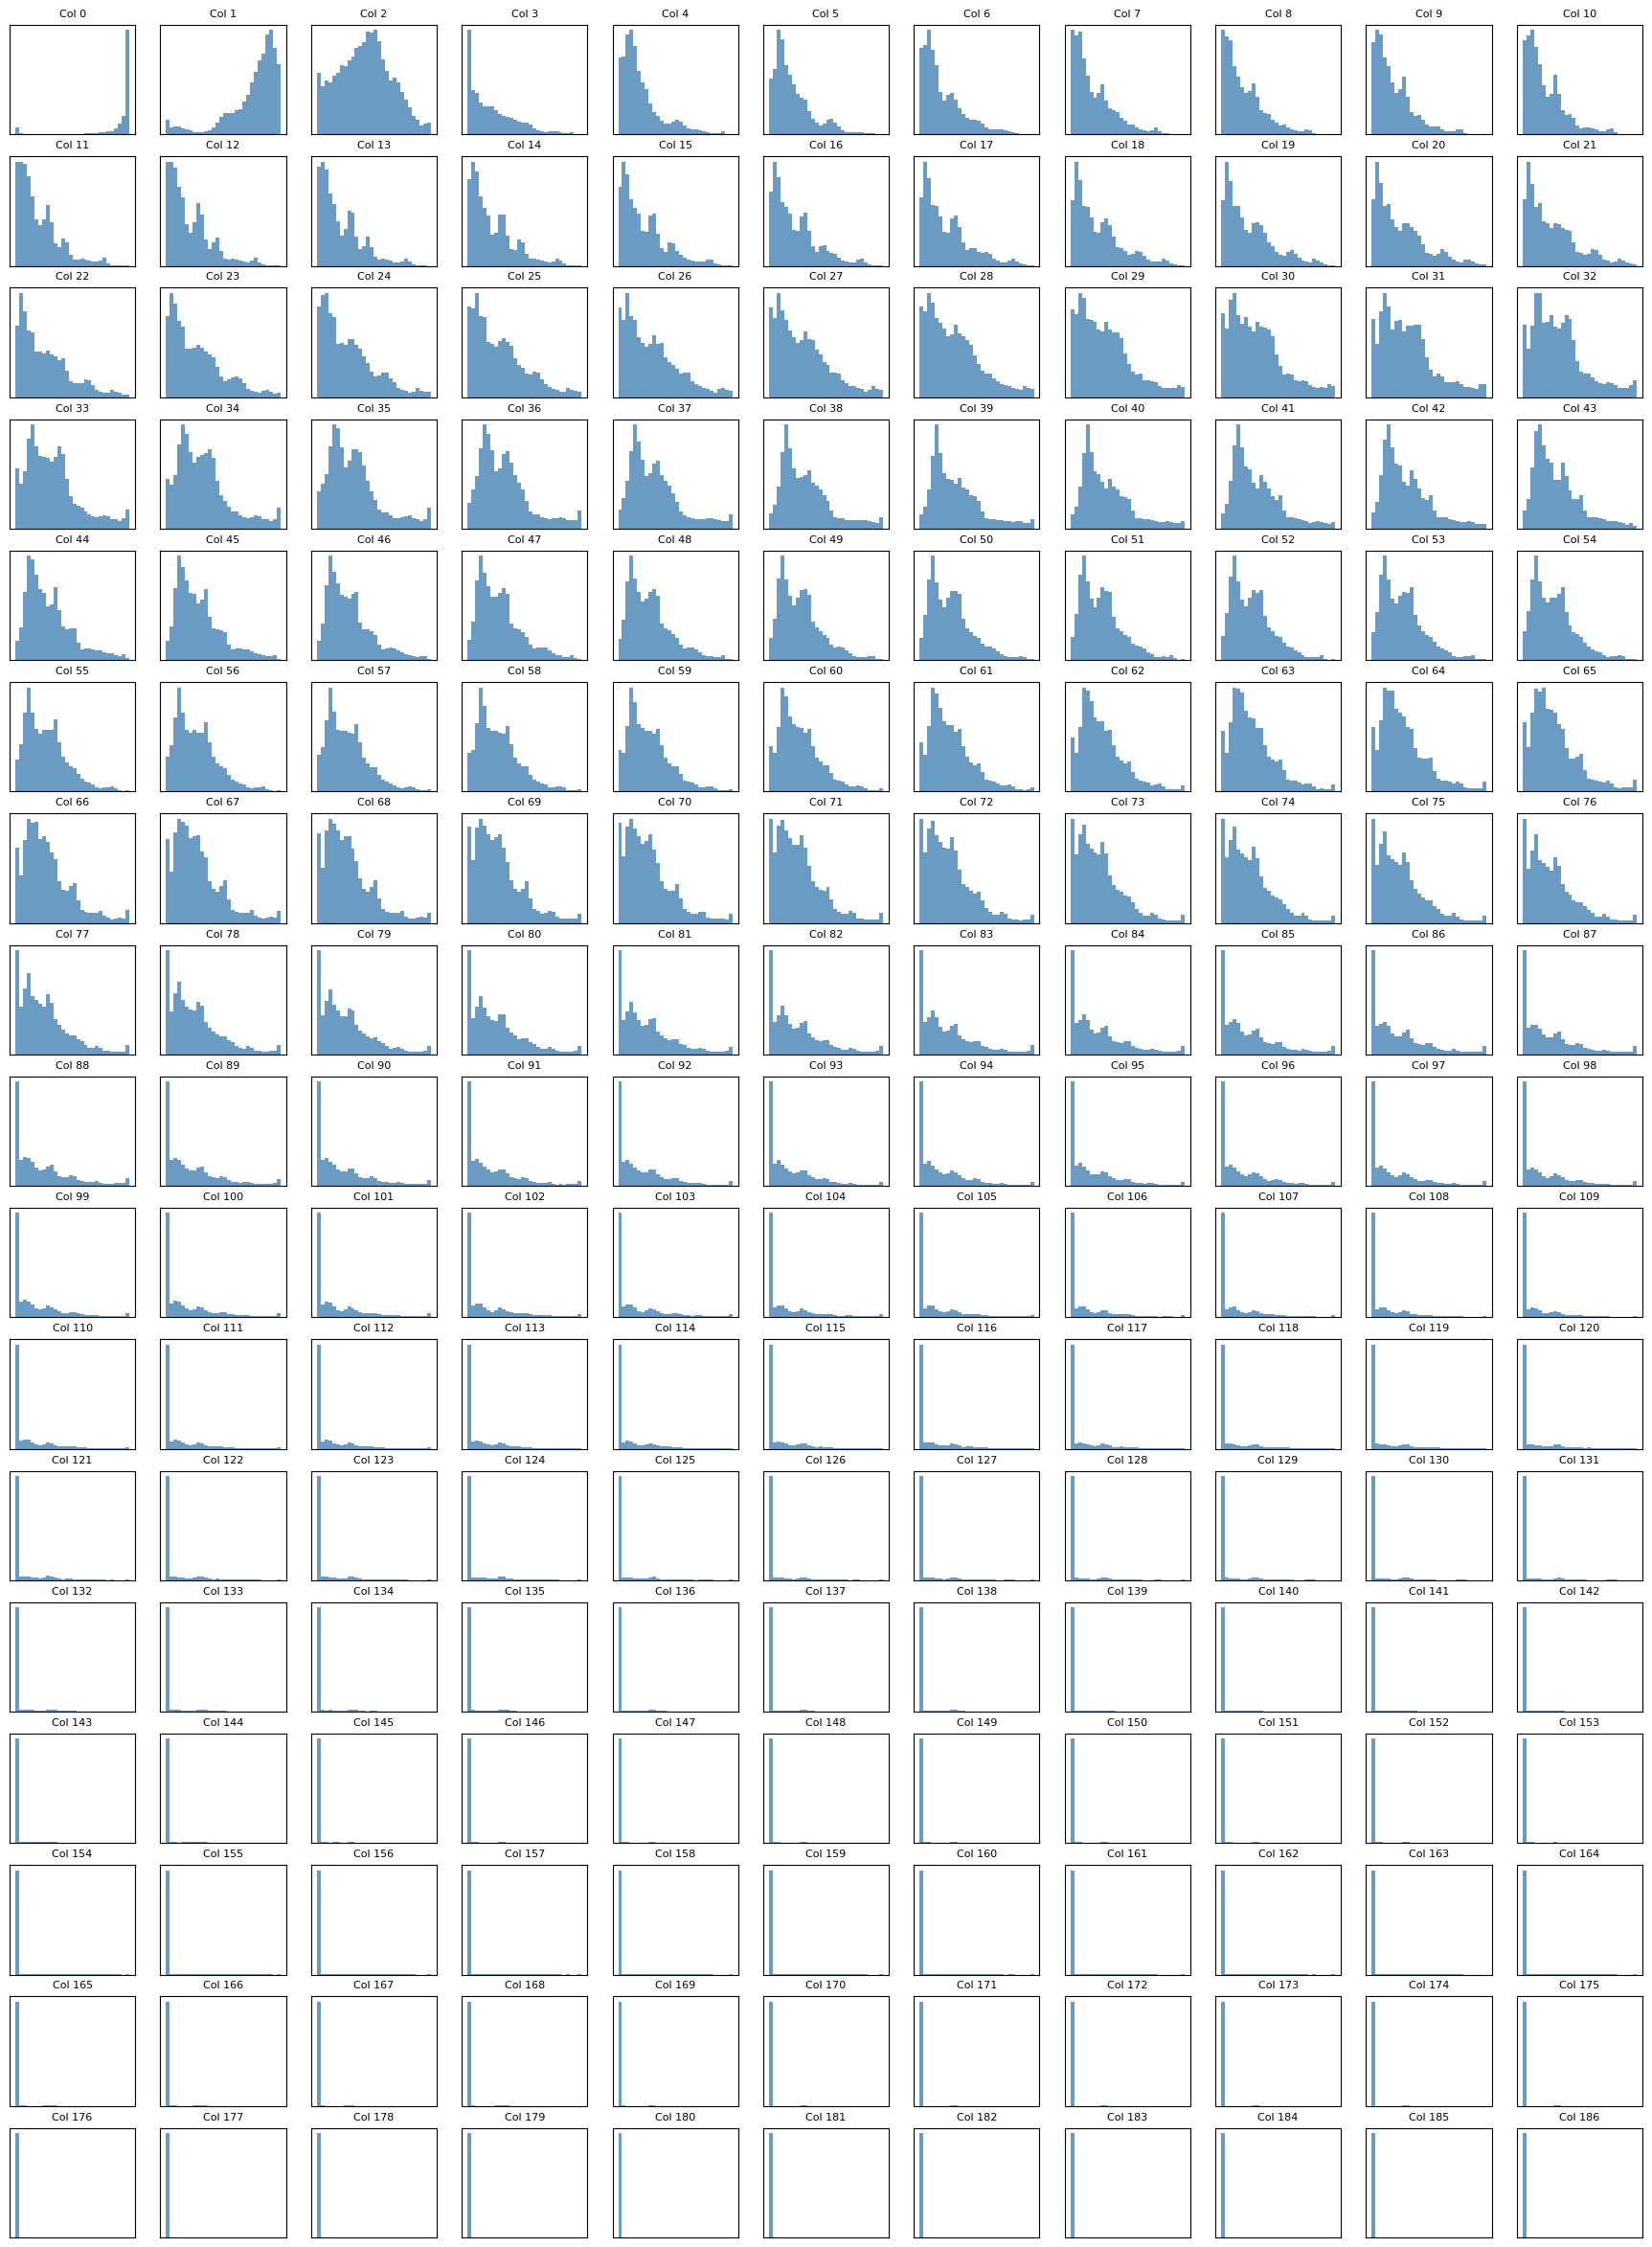

In [30]:

# figura con subplots en formato grid
fig, axes = plt.subplots(17, 11, figsize=(22, 30))  # Ajusta tamaño según tu entorno

# Aplanamos los ejes para iterar fácilmente
axes = axes.flatten()

# Recorremos cada columna del dataset X
for i in range(X.shape[1]):
    axes[i].hist(X.iloc[:, i], bins=30, color='steelblue', alpha=0.8)
    axes[i].set_title(f'Col {i}', fontsize=8)
    axes[i].set_xticks([])
    axes[i].set_yticks([])




Columnas 0 a 3:
Estas posiciones muestran formas de distribución muy distintas al resto. Algunas presentan valores máximos al principio (como en la columna 0). Esto sugiere que corresponden a los primeros instantes del latido, con alta variabilidad entre registros, probablemente por picos iniciales o porque algunas señales empiecen antes o después.

Columnas 4 a 89 aproximadamente:
En esta franja, la distribución de los valores se vuelve más regular y similar entre columnas. Predomina una concentración de valores bajos con colas a la derecha. Estas posiciones parecen corresponder a una fase activa del latido que es relativamente estable y repetitiva.

Columnas 90 a 139 aproximadamente:
Aunque las distribuciones siguen teniendo una forma similar (pico en 0 y cola hacia la derecha de manera descendente), se observa que la cantidad de valores mayores que 0 disminuye progresivamente. Esta zona actúa como una transición hacia el reposo, con menor actividad de señal en comparación con la zona anterior.

Columnas 140 en adelante:
A partir de esta sección, la gran mayoría de valores son exactamente 0. Las distribuciones están totalmente concentradas en ese punto, lo que indica que estas posiciones ya no contienen información relevante en la mayoría de los registros. Muy probablemente sean parte del relleno al final del latido.

Top 10 columnas con más valores atípicos (Z-score > 3):
0      4927
137    2660
138    2656
1      2629
139    2625
151    2624
150    2623
136    2593
149    2591
126    2583
dtype: int64


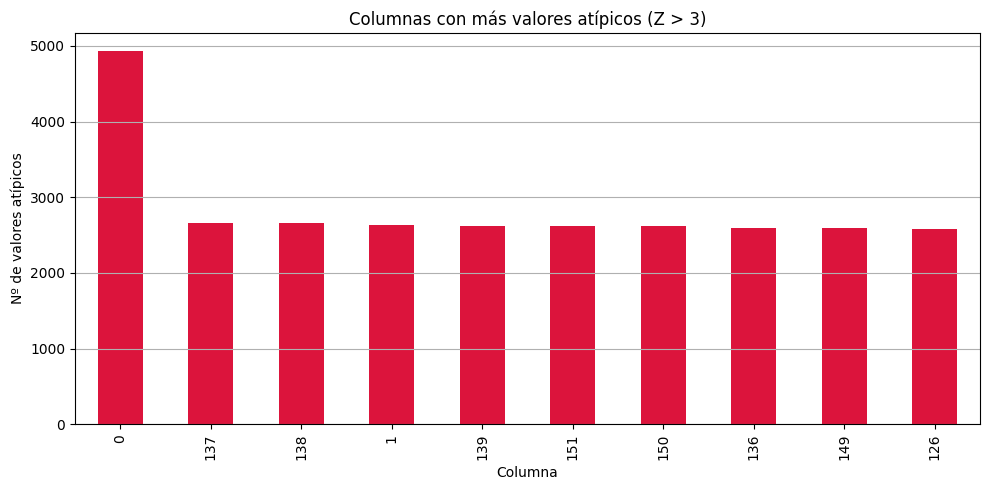

In [31]:
z_scores = abs(zscore(X))
# Convertimos a Serie con índice de nombres de columnas
atipicos_por_columna = pd.Series((z_scores > 3).sum(axis=0), index=X.columns)

# ordenar y visualizar
print("Top 10 columnas con más valores atípicos (Z-score > 3):")
print(atipicos_por_columna.sort_values(ascending=False).head(10))

top_columnas = atipicos_por_columna.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_columnas.plot(kind='bar', color='crimson')
plt.title("Columnas con más valores atípicos (Z > 3)")
plt.xlabel("Columna")
plt.ylabel("Nº de valores atípicos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


La columna 0 es la que tiene con diferencia más valores atípicos, seguida de la columna 1. Esto tiene sentido, ya que corresponden a los primeros instantes del latido, donde es normal que haya más variabilidad o picos.

Las demás columnas que aparecen con muchos valores atípicos están todas alrededor de la columna 140. Esto también encaja con lo que ya vimos: a partir de esa zona, muchas columnas tienen valores muy cercanos a 0, pero en algunos latidos aparece algún valor mayor de forma puntual. Esa mezcla hace que salgan como columnas con muchos valores extremos, aunque en realidad se debe más a esa diferencia entre registros activos e inactivos que a errores o ruido.

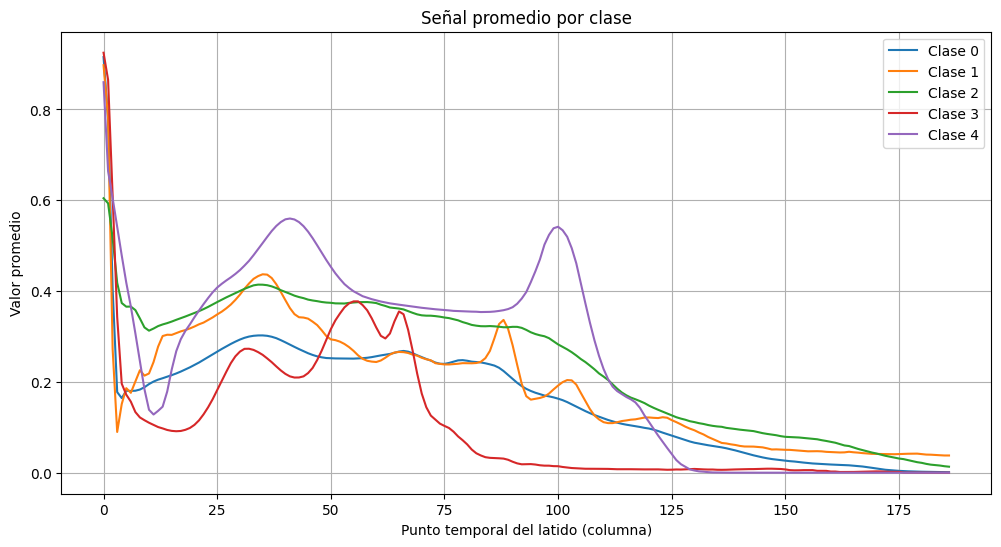

In [32]:

# copia del dataset
media_por_clase = X.copy()
media_por_clase["clase"] = y

# Agrupamos por clase y calculamos la media de cada columna
medias = media_por_clase.groupby("clase").mean()

# Graficamos
plt.figure(figsize=(12, 6))

for clase in medias.index:
    plt.plot(medias.columns, medias.loc[clase], label=f"Clase {int(clase)}")

plt.title("Señal promedio por clase")
plt.xlabel("Punto temporal del latido (columna)")
plt.ylabel("Valor promedio")
plt.legend()
plt.grid(True)
plt.show()


Todas las clases comienzan con un valor alto al principio del latido (columna 0), lo cual es coherente con la forma general del ECG.

Clase 0 (latido normal):
Tiene una señal más suave, sin picos grandes. Es más plana y estable, lo cual es esperable para latidos normales.

Clase 1 y 2:
Tienen más variaciones a lo largo del tiempo. Se observan subidas y bajadas que indican mayor actividad o complejidad en la señal. La clase 1 presenta un par de picos marcados (por ejemplo, cerca de la columna 35 y 95).

Clase 3 :
Presenta una señal muy diferente al resto, con un valor inicial bajo y una estructura muy distinta. Esto podría indicar que es un tipo de latido claramente diferenciable.

Clase 4 (ruido):
Tiene una señal con valores más altos durante casi toda la duración, incluyendo picos poco naturales. Esto confirma que esta clase puede incluir interferencias o errores de lectura en el ECG.

A partir de la columna 125, todas las señales tienden a valores muy bajos, lo cual coincide con lo que ya habíamos visto: es una zona del latido con poca o ninguna información.

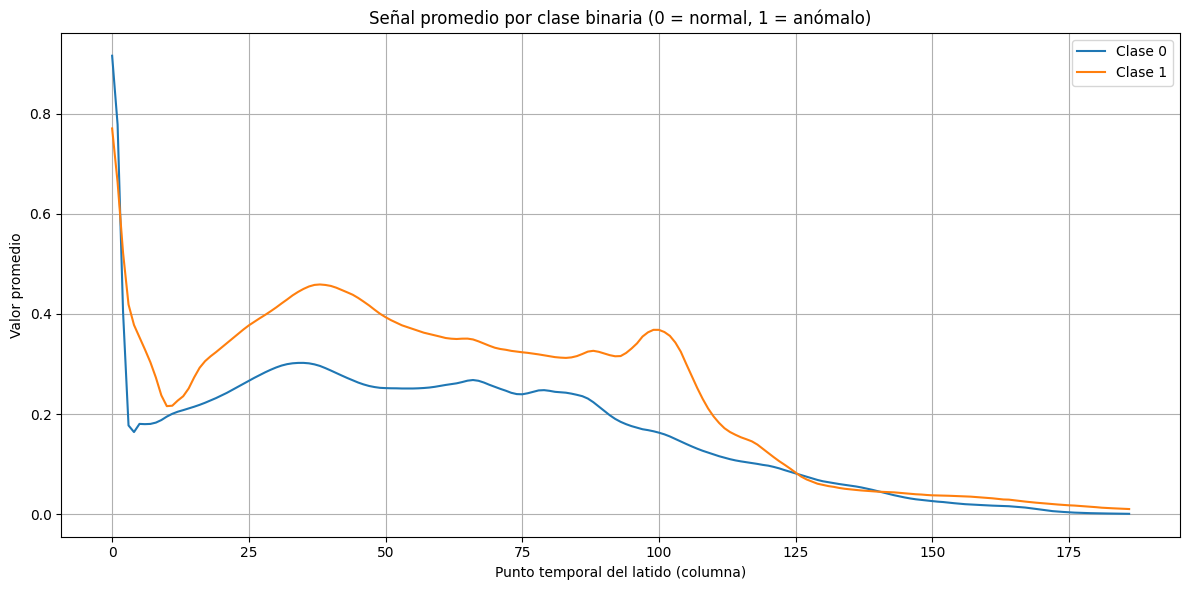

In [33]:
# Creamos una copia del dataset con la clase binaria
media_por_clase_bin = X.copy()
media_por_clase_bin["clase"] = y_binaria

# Mismos pasos que en la celda anterior
medias_bin = media_por_clase_bin.groupby("clase").mean()

plt.figure(figsize=(12, 6))

for clase in medias_bin.index:
    plt.plot(medias_bin.columns, medias_bin.loc[clase], label=f"Clase {int(clase)}")

plt.title("Señal promedio por clase binaria (0 = normal, 1 = anómalo)")
plt.xlabel("Punto temporal del latido (columna)")
plt.ylabel("Valor promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ambas clases empiezan con un pico alto en la columna 0, típico del inicio del ECG.

Clase 0 (normal) muestra una señal más baja, estable y sin grandes picos, lo que sugiere un latido regular.

Clase 1 (anómalo) mantiene valores más altos y presenta picos notables (especialmente alrededor de las columnas 35 y 100), indicando mayor actividad o irregularidad.

A partir de la columna 125, ambas clases descienden hacia valores cercanos a cero, lo que confirma que esta parte tiene poca información útil.

La zona en torno a la columna 100 destaca como potencialmente útil para definir un patrón en el Teorema de Bayes.

<ipython-input-34-2667609482>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




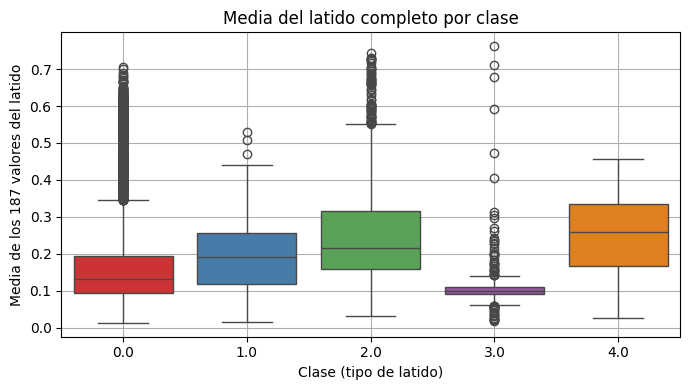

In [34]:

# Calculamos la media por fila (cada latido)
media_fila = X.mean(axis=1)

#  nuevo DataFrame
df_media = pd.DataFrame({
    "media_latido": media_fila,
    "clase": y
})

# Boxplot de la media de señal por clase
plt.figure(figsize=(7, 4))
sns.boxplot(x="clase", y="media_latido", data=df_media, palette="Set1")
plt.title("Media del latido completo por clase")
plt.xlabel("Clase (tipo de latido)")
plt.ylabel("Media de los 187 valores del latido")
plt.grid(True)
plt.tight_layout()
plt.show()

El gráfico muestra que la media de la señal varía según el tipo de latido:

Clase 0 (normal) tiene valores más bajos y estables.

Clases 1 y 2 presentan medias más altas y con más variación.

Clase 3 tiene medias bajas y muy agrupadas.

Clase 4 (ruido) muestra las medias más altas y dispersas.

<ipython-input-35-3172928543>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




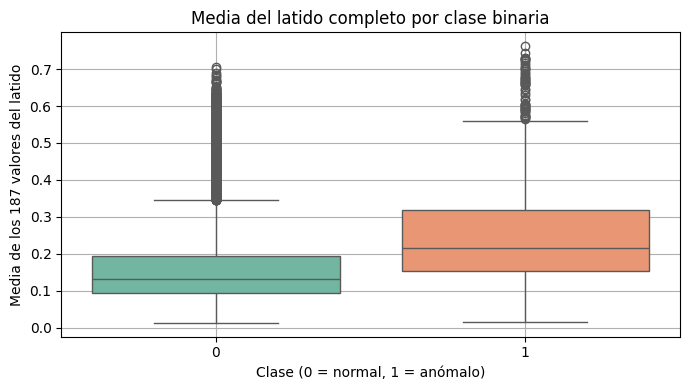

In [35]:
# Mismos pasos que la celda anterior pero para clase binaria
media_fila_binaria = X.mean(axis=1)

df_media_binaria = pd.DataFrame({
    "media_latido": media_fila_binaria,
    "clase": y_binaria  # Clase binaria: 0 = normal, 1 = anómalo
})

plt.figure(figsize=(7, 4))
sns.boxplot(x="clase", y="media_latido", data=df_media_binaria, palette="Set2")
plt.title("Media del latido completo por clase binaria")
plt.xlabel("Clase (0 = normal, 1 = anómalo)")
plt.ylabel("Media de los 187 valores del latido")
plt.grid(True)
plt.tight_layout()
plt.show()



Los latidos anómalos (clase 1) presentan una media de señal claramente más alta y dispersa que los normales (clase 0), lo que confirma que la actividad eléctrica es mayor o más irregular en los casos anómalos.

<ipython-input-36-524715044>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




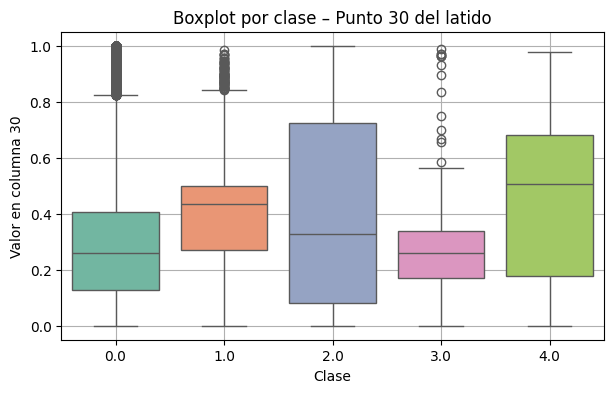

<ipython-input-36-524715044>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




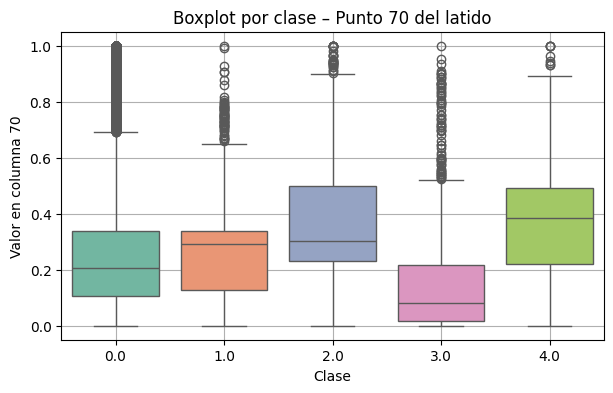

<ipython-input-36-524715044>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




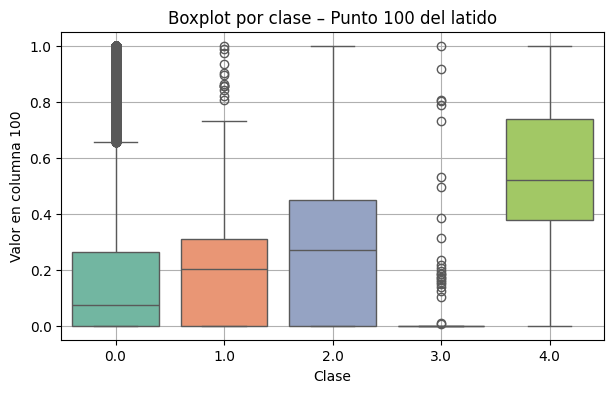

<ipython-input-36-524715044>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




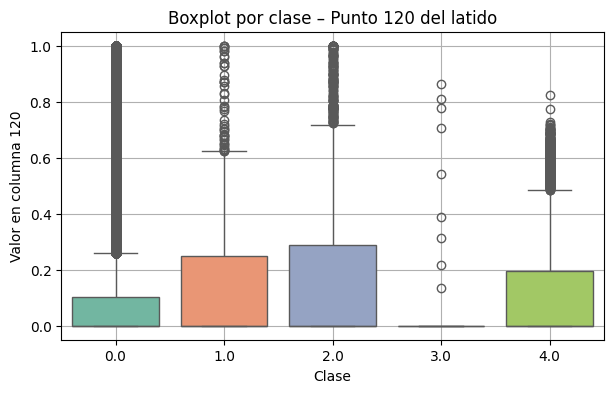

In [36]:

columnas_clave = [30, 70, 100, 120]

# Generamos un boxplot por cada punto clave del latido
for col in columnas_clave:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=y, y=X[col], palette="Set2")
    plt.title(f"Boxplot por clase – Punto {col} del latido")
    plt.xlabel("Clase")
    plt.ylabel(f"Valor en columna {col}")
    plt.grid(True)
    plt.show()


Estas gráficas solamente corroboran las conclusiones a las que hemos llegado gracias a gráficas pasadas.

<ipython-input-37-2838534157>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




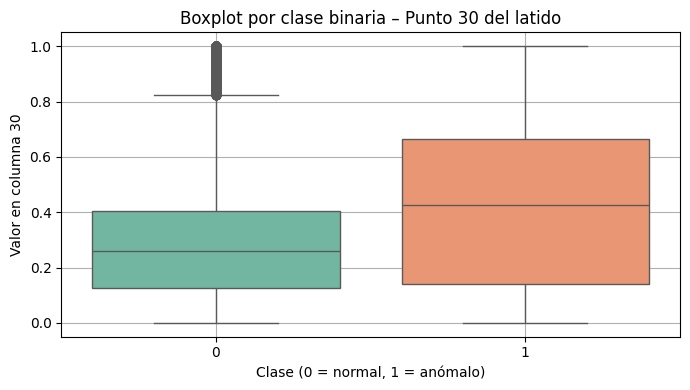

<ipython-input-37-2838534157>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




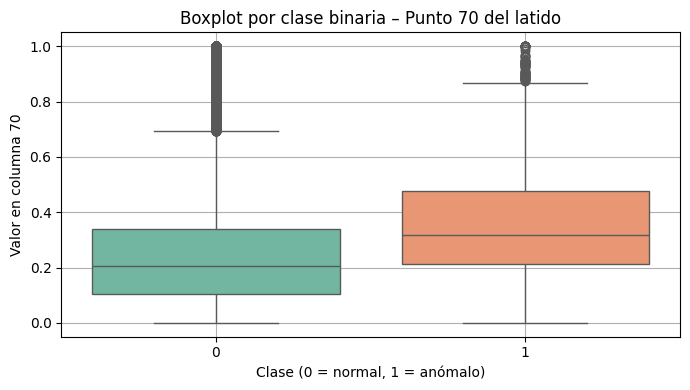

<ipython-input-37-2838534157>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




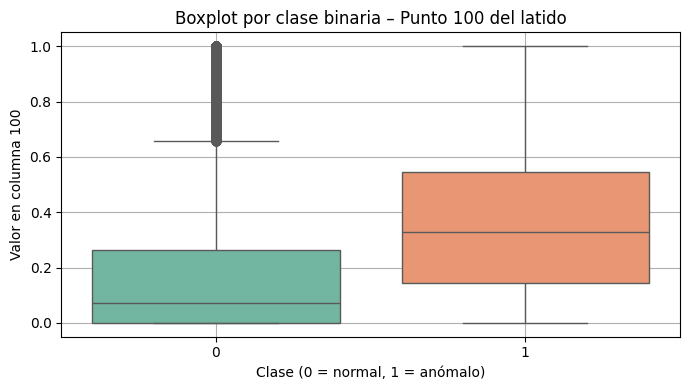

<ipython-input-37-2838534157>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




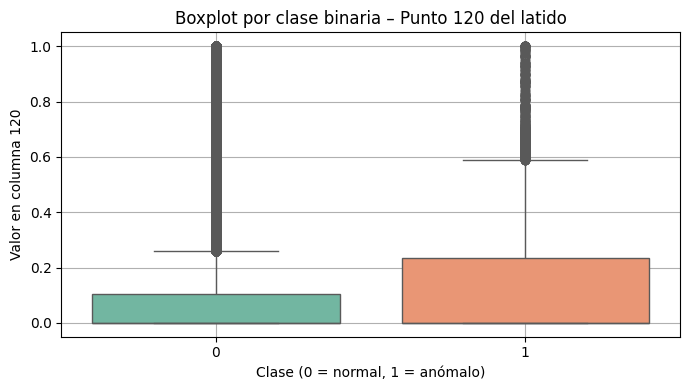

In [37]:
# mismos pasos que la celda de código anterior peor para clase binaria
columnas_clave = [30, 70, 100, 120]

for col in columnas_clave:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=y_binaria, y=X[col], palette="Set2")
    plt.title(f"Boxplot por clase binaria – Punto {col} del latido")
    plt.xlabel("Clase (0 = normal, 1 = anómalo)")
    plt.ylabel(f"Valor en columna {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Estas representaciones representan y corroboran las interpretaciones e ideas sacadas con los gráficos mostrados más arriba

**2. Reducción de Dimensionalidad (PCA)**

In [38]:
# Aplicamos filtro para eliminar columnas con varianza casi nula
selector = VarianceThreshold(threshold=0.02)
X_filtrado = selector.fit_transform(X)

# Mostramos cómo ha quedado el conjunto de datos
print("Forma original del dataset:", X.shape)
print("Forma tras eliminar columnas casi constantes:", X_filtrado.shape)

# Guardamos las clases como y_class
y_class = y.copy()

Forma original del dataset: (87554, 187)
Forma tras eliminar columnas casi constantes: (87554, 142)


Antes de aplicar PCA, se ha realizado un filtrado para eliminar columnas con muy poca variabilidad.
Usando un umbral de varianza del 2 %, se han eliminado 45 columnas, reduciendo el conjunto de 187 a 142 columnas. Este paso se justifica porque, tal como se observó en el análisis exploratorio anterior, hay muchas columnas (especialmente a partir de la 140) con valores casi siempre iguales a cero, por lo que apenas aportan información relevante.

Eliminar estas columnas permite que el PCA se enfoque en las zonas activas y con variación real de la señal, mejorando  el estudio futuro.

In [39]:

#  PCA con 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtrado)

# Mostramos  varianza explicada
varianza_explicada = pca.explained_variance_ratio_
print("Varianza explicada por el componente 1:", round(varianza_explicada[0] * 100, 2), "%")
print("Varianza explicada por el componente 2:", round(varianza_explicada[1] * 100, 2), "%")
print("Varianza total explicada por los dos componentes:", round(sum(varianza_explicada) * 100, 2), "%")


Varianza explicada por el componente 1: 45.67 %
Varianza explicada por el componente 2: 10.6 %
Varianza total explicada por los dos componentes: 56.28 %


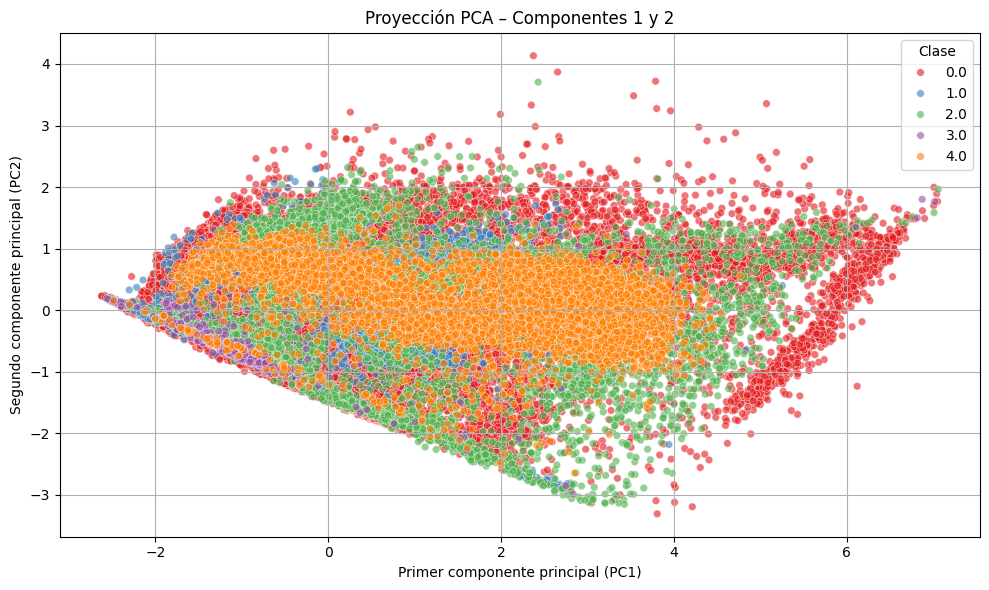

In [40]:
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Clase"] = y_class.values

# scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Clase", palette="Set1", alpha=0.6, s=30)
plt.title("Proyección PCA – Componentes 1 y 2")
plt.xlabel("Primer componente principal (PC1)")
plt.ylabel("Segundo componente principal (PC2)")
plt.legend(title="Clase", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
#  PCA con 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_filtrado)

# Creamos un DataFrame para graficar
df_pca_3d = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
df_pca_3d["Clase"] = y_class.values
# Gráfico 3D
fig = px.scatter_3d(
    df_pca_3d,
    x="PC1", y="PC2", z="PC3",
    color="Clase",
    title="PCA 3D interactivo – Componentes 1, 2 y 3",
    opacity=0.6,
    color_discrete_sequence=px.colors.qualitative.Set1,
    height=700
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [42]:
# con tres componentes
varianza_3d = pca_3d.explained_variance_ratio_
print("Varianza explicada por el componente 1:", round(varianza_3d[0] * 100, 2), "%")
print("Varianza explicada por el componente 2:", round(varianza_3d[1] * 100, 2), "%")
print("Varianza explicada por el componente 3:", round(varianza_3d[2] * 100, 2), "%")
print("Varianza total explicada por los tres componentes:", round(sum(varianza_3d) * 100, 2), "%")


Varianza explicada por el componente 1: 45.67 %
Varianza explicada por el componente 2: 10.6 %
Varianza explicada por el componente 3: 6.94 %
Varianza total explicada por los tres componentes: 63.22 %


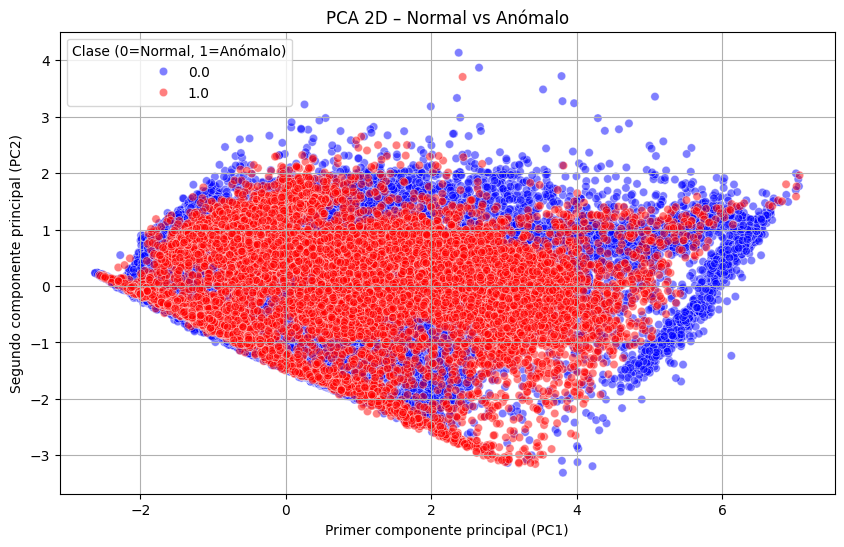

In [43]:
#A contuación vamos a realizar los mismos plots pero diferenciando entre normal vs anómalo
# Transformamos y_class a binario (0 = normal, 1 = anómalo)
y_binario = y_class.copy()
y_binario[y_binario != 0] = 1

df_pca_binario = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca_binario["Clase binaria"] = y_binario.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca_binario, x="PC1", y="PC2", hue="Clase binaria", palette=["blue", "red"], alpha=0.5)
plt.title("PCA 2D – Normal vs Anómalo")
plt.xlabel("Primer componente principal (PC1)")
plt.ylabel("Segundo componente principal (PC2)")
plt.legend(title="Clase (0=Normal, 1=Anómalo)")
plt.grid(True)
plt.show()

In [54]:

df_pca_3d_bin = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
df_pca_3d_bin["Clase"] = y_binario.astype(str)  # convierto a string para que sean categorías

colores_binarios = ["blue", "red"]

fig = px.scatter_3d(
    df_pca_3d_bin,
    x="PC1", y="PC2", z="PC3",
    color="Clase",
    color_discrete_sequence=colores_binarios,
    title="PCA 3D – Latidos normales vs anómalos",
    opacity=0.6,
    height=700
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

**3. Modelos de Clasificación**

In [45]:
# Cargar conjunto de test
df_test = pd.read_csv("mitbih_test.csv", header=None)

# Separar X e y
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# Binarizar las etiquetas de test (0 = normal, 1 = anómalo)
y_test_binario = y_test.copy()
y_test_binario[y_test_binario != 0] = 1

# Igualar columnas al conjunto de entrenamiento (sabemos que X_filtrado tiene 142 columnas) (lo hicimos al comienzo del ejericcio 2, antes del PCA)
columnas_entrenamiento = X_filtrado.shape[1]
X_test_filtrado = X_test.iloc[:, :columnas_entrenamiento]

# Comprobación (deben tener las mismas columnas obviamente)
print("Columnas en X_filtrado:", X_filtrado.shape[1])
print("Columnas en X_test_filtrado:", X_test_filtrado.shape[1])

Columnas en X_filtrado: 142
Columnas en X_test_filtrado: 142


--- Regresión Logística ---
              precision    recall  f1-score   support

         0.0     0.9466    0.8551    0.8985     18118
         1.0     0.5248    0.7684    0.6237      3774

    accuracy                         0.8401     21892
   macro avg     0.7357    0.8117    0.7611     21892
weighted avg     0.8739    0.8401    0.8511     21892



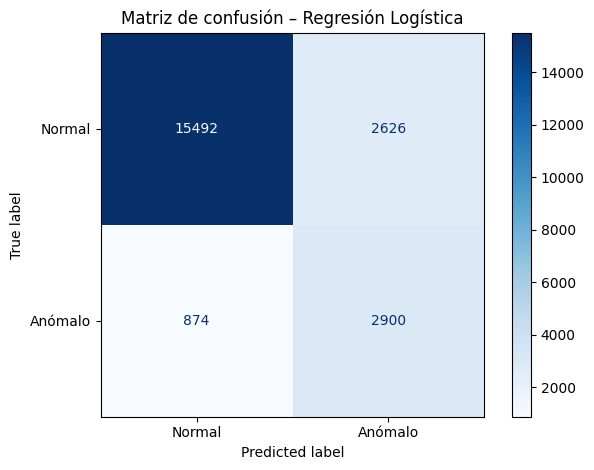

In [58]:
# --- Regresión logística ---

modelo_logistico = LogisticRegression(
    C=10,
    solver='lbfgs',
    penalty='l2',
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

# Entrenamiento
modelo_logistico.fit(X_filtrado, y_binario)

# Predicción
y_pred_log = modelo_logistico.predict(X_test_filtrado)

# Evaluación
print("--- Regresión Logística ---")
print(classification_report(y_test_binario, y_pred_log, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test_binario, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anómalo"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión – Regresión Logística")
plt.grid(False)
plt.tight_layout()
plt.show()

--- Árbol de Decisión ---
              precision    recall  f1-score   support

         0.0     0.9762    0.9753    0.9757     18118
         1.0     0.8818    0.8858    0.8838      3774

    accuracy                         0.9598     21892
   macro avg     0.9290    0.9305    0.9298     21892
weighted avg     0.9599    0.9598    0.9599     21892



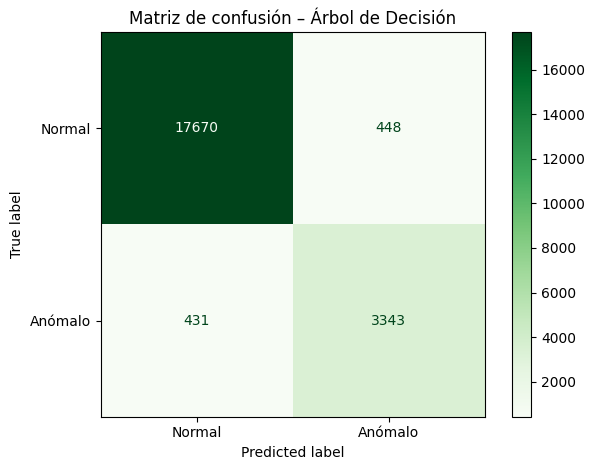

In [60]:
# --- Árbol de decisión ---

modelo_arbol = DecisionTreeClassifier(
    max_depth=20,
    class_weight='balanced',
    random_state=42
)
modelo_arbol.fit(X_filtrado, y_binario)

# Predicción
y_pred_arbol = modelo_arbol.predict(X_test_filtrado)

# Evaluación
print("--- Árbol de Decisión ---")
print(classification_report(y_test_binario, y_pred_arbol, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test_binario, y_pred_arbol)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anómalo"])
disp.plot(cmap="Greens")
plt.title("Matriz de confusión – Árbol de Decisión")
plt.grid(False)
plt.tight_layout()
plt.show()


--- Clasificador Bayesiano ---
              precision    recall  f1-score   support

         0.0     0.9147    0.8135    0.8611     18118
         1.0     0.4153    0.6359    0.5025      3774

    accuracy                         0.7829     21892
   macro avg     0.6650    0.7247    0.6818     21892
weighted avg     0.8286    0.7829    0.7993     21892



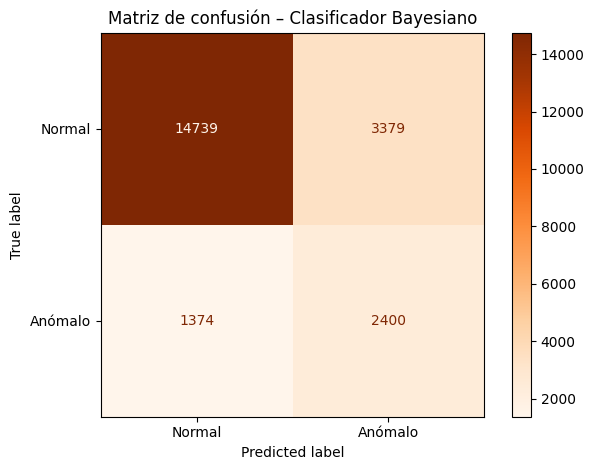

In [59]:
#--- Clasificador bayesiano ---

# Entrenamiento
modelo_bayes = GaussianNB()
modelo_bayes.fit(X_filtrado, y_binario)

# Predicción
y_pred_bayes = modelo_bayes.predict(X_test_filtrado)

# Evaluación
print("--- Clasificador Bayesiano ---")
print(classification_report(y_test_binario, y_pred_bayes, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test_binario, y_pred_bayes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anómalo"])
disp.plot(cmap="Oranges")
plt.title("Matriz de confusión – Clasificador Bayesiano")
plt.grid(False)
plt.tight_layout()
plt.show()


**Comparativa completa de modelos de clasificación binaria**

| Métrica                  | Regresión Logística | Árbol de Decisión | Clasificador Bayesiano |
|--------------------------|---------------------|--------------------|--------------------------|
| Accuracy                 | 0.8401              | **0.9598**         | 0.7829                   |
| Precision (0)           | 0.9466              | **0.9762**         | 0.9147                   |
| Recall (0)              | 0.8551              | **0.9753**         | 0.8135                   |
| F1 (0)                  | 0.8985              | **0.9757**         | 0.8611                   |
| Precision (1)           | 0.5248              | **0.8818**         | 0.4153                   |
| Recall (1)              | 0.7684              | **0.8858**         | 0.6359                   |
| F1 (1)                  | 0.6237              | **0.8838**         | 0.5025                   |
| Macro avg F1            | 0.7611              | **0.9298**         | 0.6818                   |
| Falsos Negativos (FN)   | 874                 | **431**            | 1374                     |
| Falsos Positivos (FP)   | 2626                | **448**            | 3379                     |
| Verdaderos Negativos (TN) | 15492             | **17670**          | 14739                    |
| Verdaderos Positivos (TP) | 2900              | **3343**           | 2400                     |



Como podemos ver en la tabla anterior, el **modelo de Árbol de Decisión** supera al resto de modelos en todas las métricas evaluadas. Además, es el que **menor número de falsos negativos (FN)** genera, lo cual es un aspecto **crítico desde el punto de vista clínico**, ya que implica **menos latidos anómalos clasificados erróneamente como normales**.

Por todo ello, el modelo de Árbol de Decisión es el más equilibrado y eficaz, tanto técnica como funcionalmente, para esta tarea.


**4. Probabilidades Condicionales y Teorema de Bayes**

In [50]:
#Trabajamos primero con la clasificación original y porbaprobamos con el siguiente patron, en el informe explico porqué esta elección concretamente
X_filtrado_df = pd.DataFrame(X_filtrado)
# Filtramos solo las clases 0 y 3
mask_clases = y_class.isin([0, 3])
X_bayes = X_filtrado_df[mask_clases]
y_bayes = y_class[mask_clases]
# Condición del patrón: columna 70 > 0.2
patron = (X_bayes.iloc[:, 70] >= 0.02) & (X_bayes.iloc[:, 70] <= 0.22)
#  marginales
p_clase_0 = (y_bayes == 0).mean()
p_clase_3 = (y_bayes == 3).mean()
# condicionales
p_patron_dado_0 = ((patron) & (y_bayes == 0)).sum() / (y_bayes == 0).sum()
p_patron_dado_3 = ((patron) & (y_bayes == 3)).sum() / (y_bayes == 3).sum()
# Probabilidad total del propio patrón
p_patron = patron.mean()

# Teorema de Bayes
p_0_dado_patron = (p_patron_dado_0 * p_clase_0) / p_patron
p_3_dado_patron = (p_patron_dado_3 * p_clase_3) / p_patron

# Resultados
print("P(clase = 0):", round(p_clase_0, 4))
print("P(clase = 3):", round(p_clase_3, 4))
print("P(patrón | clase = 0):", round(p_patron_dado_0, 4))
print("P(patrón | clase = 3):", round(p_patron_dado_3, 4))
print("P(patrón):", round(p_patron, 4))
print("P(clase = 0 | patrón):", round(p_0_dado_patron, 4))
print("P(clase = 3 | patrón):", round(p_3_dado_patron, 4))


P(clase = 0): 0.9912
P(clase = 3): 0.0088
P(patrón | clase = 0): 0.4646
P(patrón | clase = 3): 0.4789
P(patrón): 0.4647
P(clase = 0 | patrón): 0.991
P(clase = 3 | patrón): 0.009


In [51]:
#A continuación trabajamos con la clase binaria pero esta vez con dos patrones

#Seguimos los mismos pasos que las celdas de código anteriores

# Aplicamos el patrón: valor en columna 30 mayor que 0.5
patron = X.iloc[:, 30] > 0.5

p_clase_0 = (y_binaria == 0).mean()
p_clase_1 = (y_binaria == 1).mean()

p_patron_dado_0 = ((patron) & (y_binaria == 0)).sum() / (y_binaria == 0).sum()
p_patron_dado_1 = ((patron) & (y_binaria == 1)).sum() / (y_binaria == 1).sum()

p_patron = patron.mean()

p_0_dado_patron = (p_patron_dado_0 * p_clase_0) / p_patron
p_1_dado_patron = (p_patron_dado_1 * p_clase_1) / p_patron

print("P(clase = 0):", round(p_clase_0, 4))
print("P(clase = 1):", round(p_clase_1, 4))
print("P(patrón | clase = 0):", round(p_patron_dado_0, 4))
print("P(patrón | clase = 1):", round(p_patron_dado_1, 4))
print("P(patrón):", round(p_patron, 4))
print("P(clase = 0 | patrón):", round(p_0_dado_patron, 4))
print("P(clase = 1 | patrón):", round(p_1_dado_patron, 4))


P(clase = 0): 0.8277
P(clase = 1): 0.1723
P(patrón | clase = 0): 0.1289
P(patrón | clase = 1): 0.4099
P(patrón): 0.1773
P(clase = 0 | patrón): 0.6017
P(clase = 1 | patrón): 0.3983


In [52]:
# Aplicamos el patrón: valor en columna 100 menor que 0.2
patron = X.iloc[:, 100] < 0.2

p_clase_0 = (y_binaria == 0).mean()
p_clase_1 = (y_binaria == 1).mean()

p_patron_dado_0 = ((patron) & (y_binaria == 0)).sum() / (y_binaria == 0).sum()
p_patron_dado_1 = ((patron) & (y_binaria == 1)).sum() / (y_binaria == 1).sum()

p_patron = patron.mean()

p_0_dado_patron = (p_patron_dado_0 * p_clase_0) / p_patron
p_1_dado_patron = (p_patron_dado_1 * p_clase_1) / p_patron

print("P(clase = 0):", round(p_clase_0, 4))
print("P(clase = 1):", round(p_clase_1, 4))
print("P(patrón | clase = 0):", round(p_patron_dado_0, 4))
print("P(patrón | clase = 1):", round(p_patron_dado_1, 4))
print("P(patrón):", round(p_patron, 4))
print("P(clase = 0 | patrón):", round(p_0_dado_patron, 4))
print("P(clase = 1 | patrón):", round(p_1_dado_patron, 4))


P(clase = 0): 0.8277
P(clase = 1): 0.1723
P(patrón | clase = 0): 0.7066
P(patrón | clase = 1): 0.2939
P(patrón): 0.6355
P(clase = 0 | patrón): 0.9203
P(clase = 1 | patrón): 0.0797
